# Data reading and processing

In [355]:
%load_ext nb_black

import json
from scipy.stats import pearsonr
import math
import datetime

from sklearn import linear_model
from sklearn.preprocessing import FunctionTransformer
import matplotlib.pyplot as plt
import numpy as np
import statistics
import pandas as pd


def get_usd_timeseries(file):
    f = open(file)
    data = json.load(f)
    f.close()
    return [price for (timestamp, price) in data["prices"]]


def get_volume_timeseries(file):
    f = open(file)
    data = json.load(f)
    f.close()
    prices = get_usd_timeseries(file)
    volumes = []
    for i in range(len(data["total_volumes"])):
        (timestamp, usd_volume) = data["total_volumes"][i]
        volumes.append(usd_volume / prices[i])
    return volumes


def get_daily_volumes_dict(file):
    f = open(file)
    data = json.load(f)
    f.close()
    prices = get_usd_timeseries(file)
    volumes = dict()
    for i in range(len(data["total_volumes"])):
        (timestamp, usd_volume) = data["total_volumes"][i]
        volumes[timestamp] = usd_volume
    return volumes


def determine_price_between_assets(asset_1_prices, asset_2_prices):
    return [
        asset_1_price / asset_2_price
        for (asset_1_price, asset_2_price) in zip(asset_1_prices, asset_2_prices)
    ]


def prices_to_returns(prices):
    return [(prices[i] / prices[i - 1] - 1) for i in range(1, len(prices))]


def round_timestamp_to_nearest_gmt_date(unix_timestamp):
    import os

    date_format = "%d/%m/%Y"
    os.environ["TZ"] = "GMT"
    parsed_date = datetime.datetime.fromtimestamp(
        int(unix_timestamp) / 1000.0
    ).strftime(date_format)
    return (
        int(datetime.datetime.strptime(parsed_date, date_format).timestamp() + 3600)
        * 1000
    )


def read_trading_data(file):
    # Assumes Binance format
    # https://github.com/binance/binance-public-data/#trades
    names = [
        "trade_id",
        "price",
        "qty",
        "quote_qty",
        "time",
        "is_buyer_maker",
        "is_best_match",
    ]
    df = pd.read_csv(file, names=names)
    return df.drop(columns=["trade_id", "quote_qty", "is_best_match"])


def clean_trading_data_consecutively(
    trading_data, daily_volumes_dict, max_item_count, min_total_qty, min_price_change
):
    # simplify df to be ready for regression
    cleaned_df = pd.DataFrame(columns=["qty", "caused_price_change"])
    cleaned_df_index = 0
    prev_price = 1
    prev_qty = 0
    prev_nearest_date = 0
    prev_qty_to_volume_ratio = 0
    prev_is_buyer_maker = False
    i = -1
    while i < len(trading_data.index):
        i += 1
        row = trading_data.iloc[i]
        if row["is_buyer_maker"] == True:
            continue
        initial_price = row["price"]
        j = i
        total_qty = 0
        while row["is_buyer_maker"] == False and j < len(trading_data.index):
            row = trading_data.iloc[j]
            total_qty += row["qty"]
            j += 1
        price_change = (row["price"] / initial_price) - 1
        if i == j or total_qty < min_total_qty or price_change < min_price_change:
            continue
        cleaned_df.loc[cleaned_df_index] = [
            total_qty,
            price_change,
        ]
        cleaned_df_index += 1
        print("Added elements: " + str(cleaned_df_index))
        i = j
        if cleaned_df_index > max_item_count:
            break
    return cleaned_df


# KSM/USD daily (01/01/2021 - 09/09/2021): https://api.coingecko.com/api/v3/coins/kusama/market_chart/range?vs_currency=usd&from=1609459200&to=1631189591
# DOT/USD daily (01/01/2021 - 09/09/2021): https://api.coingecko.com/api/v3/coins/polkadot/market_chart/range?vs_currency=usd&from=1609459200&to=1631189591
# Bitcoin/USD daily (01/01/2021 - 09/09/2021): https://api.coingecko.com/api/v3/coins/bitcoin/market_chart/range?vs_currency=usd&from=1609459200&to=1631189591
# `./download_trades` script made to download Binance data

ksm_to_usd_daily = get_usd_timeseries("kusama_to_usd_daily_2021.json")
ksm_usd_returns_daily = prices_to_returns(ksm_to_usd_daily)

dot_to_usd_daily = get_usd_timeseries("polkadot_to_usd_daily_2021.json")
dot_usd_returns_daily = prices_to_returns(dot_to_usd_daily)

btc_to_usd_daily = get_usd_timeseries("bitcoin_to_usd_daily_2021.json")
btc_usd_returns_daily = prices_to_returns(btc_to_usd_daily)

ksm_to_btc_daily = determine_price_between_assets(ksm_to_usd_daily, btc_to_usd_daily)
ksm_to_btc_returns_daily = prices_to_returns(ksm_to_btc_daily)
observed_ksm_btc_corr, _ = pearsonr(ksm_usd_returns_daily, btc_usd_returns_daily)


dot_to_btc_daily = determine_price_between_assets(dot_to_usd_daily, btc_to_usd_daily)
dot_to_btc_returns_daily = prices_to_returns(dot_to_btc_daily)
observed_dot_btc_corr, _ = pearsonr(dot_usd_returns_daily, btc_usd_returns_daily)

ksm_daily_volumes = get_volume_timeseries("kusama_to_usd_daily_2021.json")
ksm_volumes_dict = get_daily_volumes_dict("kusama_to_usd_daily_2021.json")

dot_daily_volumes = get_volume_timeseries("polkadot_to_usd_daily_2021.json")
dot_volumes_dict = get_daily_volumes_dict("polkadot_to_usd_daily_2021.json")

btc_daily_volumes = get_volume_timeseries("bitcoin_to_usd_daily_2021.json")
btc_volumes_dict = get_daily_volumes_dict("bitcoin_to_usd_daily_2021.json")

print("KSM/BTC correlation is: " + str(observed_ksm_btc_corr))
print("DOT/BTC correlation is: " + str(observed_dot_btc_corr))

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black
KSM/BTC correlation is: 0.585108270360336
DOT/BTC correlation is: 0.6671882591466916


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [344]:
btc_raw_trading_data = read_trading_data("BTC_trades.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [342]:
# Filter data to only keep extreme cases, to train a conservative slippage model
btc_trading_data = clean_trading_data_consecutively(
    btc_raw_trading_data, btc_volumes_dict, 20, 5, 0.000001
)

Added elements: 1
Added elements: 2
Added elements: 3
Added elements: 4
Added elements: 5
Added elements: 6
Added elements: 7
Added elements: 8
Added elements: 9
Added elements: 10
Added elements: 11
Added elements: 12
Added elements: 13
Added elements: 14
Added elements: 15
Added elements: 16
Added elements: 17
Added elements: 18
Added elements: 19
Added elements: 20
Added elements: 21


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [345]:
ksm_raw_trading_data = read_trading_data("KSM_trades.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [348]:
# Filter data to only keep extreme cases, to train a conservative slippage model
ksm_trading_data = clean_trading_data_consecutively(
    ksm_raw_trading_data, ksm_volumes_dict, 10, 10, 0.006
)

Added elements: 1
Added elements: 2
Added elements: 3
Added elements: 4
Added elements: 5
Added elements: 6
Added elements: 7
Added elements: 8
Added elements: 9
Added elements: 10
Added elements: 11


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [346]:
dot_raw_trading_data = read_trading_data("DOT_trades.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [347]:
# Filter data to only keep extreme case, to train a conservative slippage model
dot_trading_data = clean_trading_data_consecutively(
    dot_raw_trading_data, dot_volumes_dict, 50, 200, 0.0005
)

Added elements: 1
Added elements: 2
Added elements: 3
Added elements: 4
Added elements: 5
Added elements: 6
Added elements: 7
Added elements: 8
Added elements: 9
Added elements: 10
Added elements: 11
Added elements: 12
Added elements: 13
Added elements: 14
Added elements: 15
Added elements: 16
Added elements: 17
Added elements: 18
Added elements: 19
Added elements: 20
Added elements: 21
Added elements: 22
Added elements: 23
Added elements: 24
Added elements: 25
Added elements: 26
Added elements: 27
Added elements: 28
Added elements: 29
Added elements: 30
Added elements: 31
Added elements: 32
Added elements: 33
Added elements: 34
Added elements: 35
Added elements: 36
Added elements: 37
Added elements: 38
Added elements: 39
Added elements: 40
Added elements: 41
Added elements: 42
Added elements: 43
Added elements: 44
Added elements: 45
Added elements: 46
Added elements: 47
Added elements: 48
Added elements: 49
Added elements: 50
Added elements: 51


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

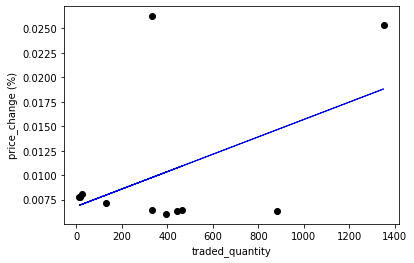

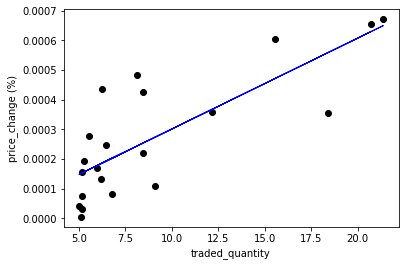

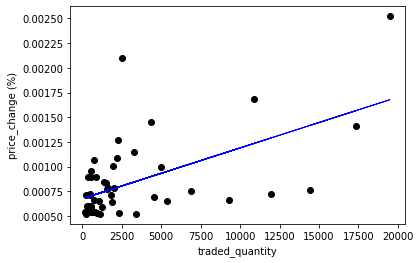

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [349]:
def get_regression_model(trading_data, min_price_change=None, max_qty=None):
    filtered_data = trading_data
    if min_price_change and max_qty:
        filtered_data = filtered_data[
            (filtered_data["caused_price_change"] > 0.01) & (filtered_data["qty"] < 400)
        ]
    x = filtered_data.qty.values
    y = filtered_data.caused_price_change.values

    x = x.reshape(len(x), 1)
    y = y.reshape(len(x), 1)

    regr = linear_model.LinearRegression()
    result = regr.fit(x, y)
    model = result.predict
    plt.scatter(x, y, color="black")
    plt.plot(x, model(x), color="blue", linewidth=1)
    plt.ylabel("price_change (%)")
    plt.xlabel("traded_quantity")
    plt.show()
    return model


ksm_liquidity_model = get_regression_model(ksm_trading_data)
btc_liquidity_model = get_regression_model(btc_trading_data)
dot_liquidity_model = get_regression_model(dot_trading_data)

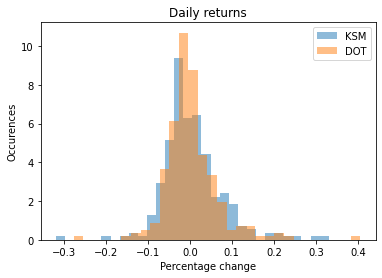

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [358]:
def plot_returns(returns, data_label, title):
    plt.hist(returns, density=True, bins=30, alpha=0.5, label=data_label)
    plt.ylabel("Occurences")
    plt.xlabel("Percentage change")
    plt.legend(loc="upper right")
    plt.title(title)


plot_returns(ksm_to_btc_returns_daily, "KSM", "Daily returns")
plot_returns(dot_to_btc_returns_daily, "DOT", "Daily returns")

# Monte Carlo Simulation
https://arxiv.org/pdf/2002.08099.pdf

Independently simulates the prices of collateral and BTC.

Selects the worst collateral/USD price trajectory, then picks the BTC/USD price trajectory that has the closest pearson correlation to the one in the real data sample.

All vaults are considered a single entity, but they are separated from the liquidation vault. When vaults become undercollateralized, liquidators acquire as much liquidity as possible to arbitrage, taking slippage into account. Liquidators are assumed ot start up their own vault before liquidating, so both collateral and Bitcoin liquidity need to be modelled.

Even if slippage is considered, it is assumed that prices recover by the next day. While this is an optimistic assumption, the conservative slippage model balances it out.

In [359]:
# Should simulate more scenarios
SIMULATED_SCENARIOS = 100
PRICE_PATHS_PER_SIMULATION = 500
PREDICTED_DAYS = 100

# premium redeem is skipped
PREMIUM_REDEEM_BONUS = 0.05

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [361]:
# Monte Carlo price simulation (Geometric Brownian Motion)
# Reference article: https://towardsdatascience.com/simulating-stock-prices-in-python-using-geometric-brownian-motion-8dfd6e8c6b18


def stochastic_price_simulation(
    returns, initial_price, prediction_days, scenario_count
):
    So = initial_price
    dt = 1
    T = prediction_days
    N = T / dt
    t = np.arange(1, int(N) + 1)
    mu = np.mean(returns)
    sigma = np.std(returns)
    scen_size = scenario_count
    b = {str(scen): np.random.normal(0, 1, int(N)) for scen in range(1, scen_size + 1)}
    W = {str(scen): b[str(scen)].cumsum() for scen in range(1, scen_size + 1)}

    # Calculating drift and diffusion components
    drift = (mu - 0.5 * sigma ** 2) * t
    diffusion = {str(scen): sigma * W[str(scen)] for scen in range(1, scen_size + 1)}

    # Making the predictions
    S = np.array(
        [So * np.exp(drift + diffusion[str(scen)]) for scen in range(1, scen_size + 1)]
    )
    S = np.hstack(
        (np.array([[So] for scen in range(scen_size)]), S)
    )  # add So to the beginning series

    # Plotting the simulations
    #     plt.figure(figsize = (20,10))
    #     for i in range(scen_size):
    #         plt.title("Daily Volatility: " + str(sigma))
    #         plt.plot(S[i, :])
    #         plt.ylabel('Price')
    #         plt.xlabel('Prediction Days')
    #     plt.show()
    return S


def get_worst_price_trajectory(S):
    min_price = S[0, -1]
    index = 0
    for i in range(len(S)):
        if S[i, -1] < min_price:
            min_price = S[i, -1]
            index = i
    return S[index, :]


def get_trajectory_with_closest_correlation(S, base_trajectory, corr):
    picked_trajectory = S[0, :]
    index = 0
    closest_found_correlation, _ = pearsonr(base_trajectory, S[0, :])
    for i in range(len(S)):
        tmp_corr, _ = pearsonr(base_trajectory, S[i, :])
        if abs(tmp_corr - corr) < abs(closest_found_correlation - corr):
            closest_found_correlation = tmp_corr
            picked_trajectory = S[i, :]
            index = i
    return S[index, :], closest_found_correlation


def find_profitable_volume(
    secure_threshold,
    collateral_usd,
    btc_usd,
    collateral_liquidity_model,
    btc_liquidity_model,
    liquidation_vault_issued,
    liquidation_vault_collateral,
):
    burn_exchange_rate = (
        (liquidation_vault_collateral * collateral_usd)
        / (liquidation_vault_issued * btc_usd)
        * (collateral_usd / btc_usd)
    )
    btc_amount = liquidation_vault_issued
    while btc_amount > 0:
        collateral_amount = btc_amount * btc_usd / collateral_usd * secure_threshold
        btc_price_change = btc_liquidity_model([[btc_amount]])[0][0]
        collateral_price_change = collateral_liquidity_model([[collateral_amount]])[0][
            0
        ]
        new_btc_price = btc_usd * (1 + btc_price_change)
        new_collateral_price = collateral_usd * (1 + collateral_price_change)
        # assume that if new exchange rate is equal to the burn rate,
        # we stop buying
        new_exchange_rate = new_collateral_price / new_btc_price
        if burn_exchange_rate >= new_exchange_rate:
            return btc_amount
        btc_amount -= 5
    return 0


def get_days_of_undercollateralization(
    worst_collateral_scenario_trajectory,
    correlated_btc_scenario_trajectory,
    collateral_liquidity_model,
    btc_liquidity_model,
    debt_ceiling_usd,
    secure_threshold,
    liquidation_threshold,
):
    starting_collateral_price = worst_collateral_scenario_trajectory[0]
    starting_btc_price = correlated_btc_scenario_trajectory[0]
    vaults_issued = (debt_ceiling_usd / secure_threshold) / starting_btc_price
    vaults_collateral = debt_ceiling_usd / starting_collateral_price

    liquidation_vault_issued = 0
    liquidation_vault_collateral = 0
    current_collateral_to_btc_price = starting_collateral_price / starting_btc_price

    system_collateral_daily = []
    vault_collateral_daily = []
    liquidation_vault_btc_daily = []
    daily_collateralization = []
    days_of_undercollateralization = 0
    for (collateral_usd, btc_usd) in zip(
        worst_collateral_scenario_trajectory, correlated_btc_scenario_trajectory
    ):
        current_collateral_to_btc_price = collateral_usd / btc_usd
        vault_required_collateral = vaults_issued / current_collateral_to_btc_price
        system_required_collateral = (
            vaults_issued + liquidation_vault_issued
        ) / current_collateral_to_btc_price
        system_collateral_daily.append(system_required_collateral)
        vault_collateral_daily.append(vaults_collateral)
        liquidation_vault_btc_daily.append(liquidation_vault_issued)
        system_collateralization = (
            vaults_collateral + liquidation_vault_collateral
        ) / system_required_collateral
        if (
            vaults_issued > 0
            and vaults_collateral / vault_required_collateral < liquidation_threshold
        ):
            # liquidate every vault
            liquidation_vault_issued = vaults_issued
            vaults_issued = 0
            liquidation_vault_collateral = vaults_collateral
            vaults_collateral = 0
        if liquidation_vault_issued > 0:
            btc_arbitrage_amount = find_profitable_volume(
                secure_threshold,
                collateral_usd,
                btc_usd,
                collateral_liquidity_model,
                btc_liquidity_model,
                liquidation_vault_issued,
                liquidation_vault_collateral,
            )

            # mint interbtc for the liquidation
            newly_added_collateral = (
                btc_arbitrage_amount / current_collateral_to_btc_price
            ) * secure_threshold
            vaults_issued += btc_arbitrage_amount
            vaults_collateral += newly_added_collateral

            # perform burn redeem
            burn_exchange_rate = (
                (liquidation_vault_collateral * collateral_usd)
                / (liquidation_vault_issued * btc_usd)
                * current_collateral_to_btc_price
            )
            burn_dot_payout = btc_arbitrage_amount / burn_exchange_rate
            liquidation_vault_issued -= btc_arbitrage_amount
            liquidation_vault_collateral = round(
                liquidation_vault_collateral - burn_dot_payout
            )
        daily_collateralization.append(system_collateralization)
        if system_collateralization < 1:
            days_of_undercollateralization += 1
    return (
        days_of_undercollateralization,
        daily_collateralization,
        liquidation_vault_btc_daily,
    )


def get_worst_pair_of_price_trajectories(
    scenarios_count,
    asset_corr,
    debt_ceiling_usd,
    secure_threshold,
    liquidation_threshold,
    collateral_usd_returns_daily,
    collateral_to_usd_daily,
    collateral_liquidity_model,
    btc_usd_returns_daily,
    btc_to_usd_daily,
    btc_liquidity_model,
):
    worst_btc_trajectory = []
    worst_collateral_trajectory = []
    most_days_of_undercollateralization = 0
    worst_daily_collateralization_trajectory = []
    worst_liquidation_vault_collateral_trajectory = []
    for i in range(scenarios_count):
        collateral_price_simulations = stochastic_price_simulation(
            collateral_usd_returns_daily,
            collateral_to_usd_daily[-1],
            PREDICTED_DAYS,
            PRICE_PATHS_PER_SIMULATION,
        )
        worst_collateral_scenario_trajectory = get_worst_price_trajectory(
            collateral_price_simulations
        )
        btc_price_simulations = stochastic_price_simulation(
            btc_usd_returns_daily,
            btc_to_usd_daily[-1],
            PREDICTED_DAYS,
            PRICE_PATHS_PER_SIMULATION,
        )
        (
            correlated_btc_scenario_trajectory,
            closest_found_correlation,
        ) = get_trajectory_with_closest_correlation(
            btc_price_simulations, worst_collateral_scenario_trajectory, asset_corr
        )
        (
            days_of_undercollateralization,
            daily_collateralization,
            liquidation_vault_btc_daily,
        ) = get_days_of_undercollateralization(
            worst_collateral_scenario_trajectory,
            correlated_btc_scenario_trajectory,
            collateral_liquidity_model,
            btc_liquidity_model,
            debt_ceiling_usd,
            secure_threshold,
            liquidation_threshold,
        )
        if (
            days_of_undercollateralization > most_days_of_undercollateralization
            or most_days_of_undercollateralization == 0
        ):
            most_days_of_undercollateralization = days_of_undercollateralization
            worst_btc_trajectory = correlated_btc_scenario_trajectory
            worst_collateral_trajectory = worst_collateral_scenario_trajectory
            worst_daily_collateralization_trajectory = daily_collateralization
            worst_liquidation_vault_collateral_trajectory = liquidation_vault_btc_daily
    return (
        worst_collateral_trajectory,
        worst_btc_trajectory,
        worst_daily_collateralization_trajectory,
        worst_liquidation_vault_collateral_trajectory,
        most_days_of_undercollateralization,
    )

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [364]:
%reload_ext nb_black


def plot_collateralization(
    subplot,
    liquidation_vault_issued_daily,
    daily_collateralization,
    liquidation_threshold,
):
    subplot.plot([l / 1000 for l in liquidation_vault_issued_daily])
    subplot.plot(daily_collateralization)
    subplot.plot([liquidation_threshold] * len(daily_collateralization))
    subplot.plot([1.0] * len(daily_collateralization))
    subplot.legend(
        [
            "liquidation_vault_issued (thousands)",
            "collateralization",
            "liquidation threshold",
            "undercollateralization",
        ]
    )


def plot_prices(subplot, collateral_price_trajectory, btc_price_trajectory):
    subplot.plot([price * 1000 for price in collateral_price_trajectory])
    subplot.plot(btc_price_trajectory)
    subplot.legend(["collateral price (x1000)", "btc price"])


def simulate_and_plot(
    simulated_scenarios,
    observed_collateral_to_btc_corr,
    debt_ceiling_usd,
    secure_threshold,
    liquidation_threshold,
    collateral_usd_returns_daily,
    collateral_to_usd_daily,
    collateral_liquidity_model,
    btc_usd_returns_daily,
    btc_to_usd_daily,
    btc_liquidity_model,
):
    (
        collateral_price_trajectory,
        btc_price_trajectory,
        daily_collateralization,
        liquidation_vault_issued_daily,
        days_of_undercollateralization,
    ) = get_worst_pair_of_price_trajectories(
        simulated_scenarios,
        observed_collateral_to_btc_corr,
        debt_ceiling_usd,
        secure_threshold,
        liquidation_threshold,
        collateral_usd_returns_daily,
        collateral_to_usd_daily,
        collateral_liquidity_model,
        btc_usd_returns_daily,
        btc_to_usd_daily,
        btc_liquidity_model,
    )

    print("days of undercollateralization: " + str(days_of_undercollateralization))
    fig, axs = plt.subplots(2, figsize=(12, 10))
    plot_collateralization(
        axs[0],
        liquidation_vault_issued_daily,
        daily_collateralization,
        liquidation_threshold,
    )
    plot_prices(axs[1], collateral_price_trajectory, btc_price_trajectory)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

days of undercollateralization:3


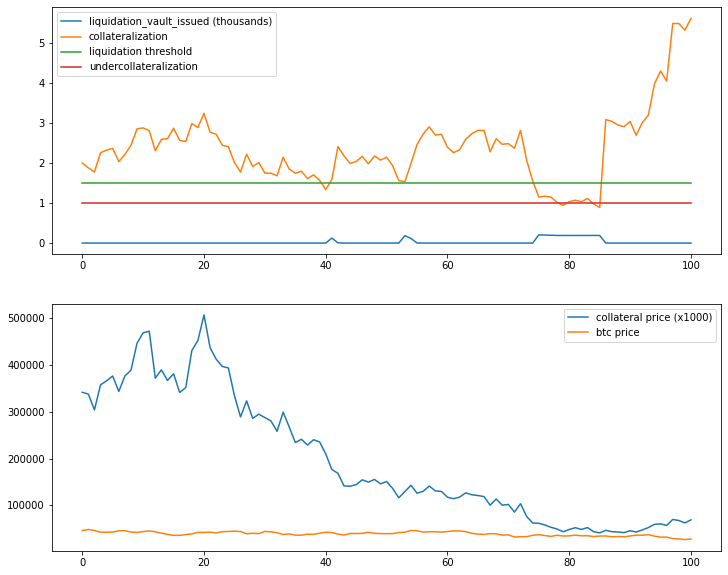

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [363]:
DEBT_CEILING_USD = 20_000_000
SECURE_THRESHOLD = 2
LIQUIDATION_THRESHOLD = 1.5
simulate_and_plot(
    SIMULATED_SCENARIOS,
    observed_ksm_btc_corr,
    DEBT_CEILING_USD,
    SECURE_THRESHOLD,
    LIQUIDATION_THRESHOLD,
    ksm_usd_returns_daily,
    ksm_to_usd_daily,
    ksm_liquidity_model,
    btc_usd_returns_daily,
    btc_to_usd_daily,
    btc_liquidity_model,
)

days of undercollateralization: 0


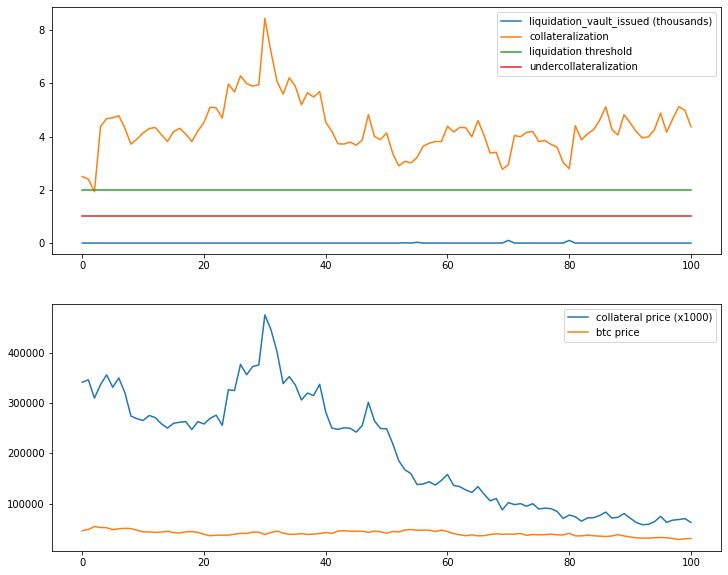

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [365]:
DEBT_CEILING_USD = 20_000_000
SECURE_THRESHOLD = 2.5
LIQUIDATION_THRESHOLD = 2
simulate_and_plot(
    SIMULATED_SCENARIOS,
    observed_ksm_btc_corr,
    DEBT_CEILING_USD,
    SECURE_THRESHOLD,
    LIQUIDATION_THRESHOLD,
    ksm_usd_returns_daily,
    ksm_to_usd_daily,
    ksm_liquidity_model,
    btc_usd_returns_daily,
    btc_to_usd_daily,
    btc_liquidity_model,
)

get_worst_pair_of_price_trajectories
days of undercollateralization:1


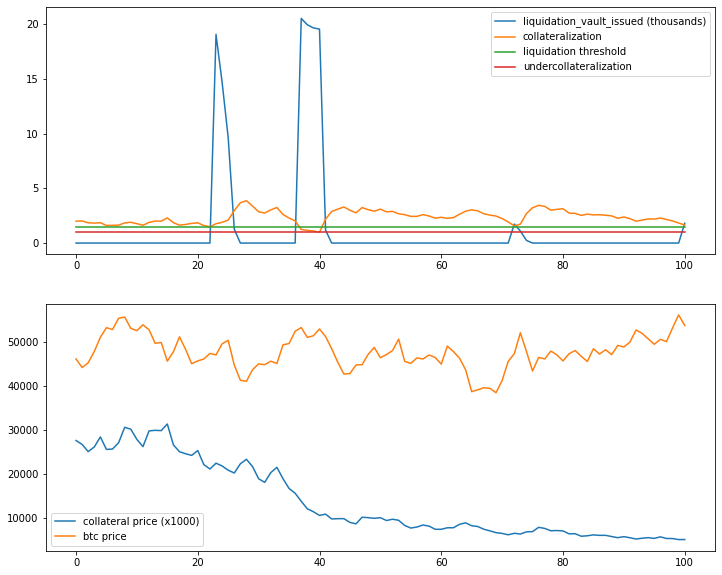

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [337]:
DEBT_CEILING_USD = 2_000_000_000
SECURE_THRESHOLD = 2.0
LIQUIDATION_THRESHOLD = 1.5
simulate_and_plot(
    SIMULATED_SCENARIOS,
    observed_dot_btc_corr,
    DEBT_CEILING_USD,
    SECURE_THRESHOLD,
    LIQUIDATION_THRESHOLD,
    dot_usd_returns_daily,
    dot_to_usd_daily,
    dot_liquidity_model,
    btc_usd_returns_daily,
    btc_to_usd_daily,
    btc_liquidity_model,
)

# Value At Risk (VAR) Model
https://ocw.mit.edu/courses/mathematics/18-s096-topics-in-mathematics-with-applications-in-finance-fall-2013/lecture-notes/MIT18_S096F13_lecnote7.pdf

In [151]:
confidence_99 = 2.33
confidence_95 = 1.64
LIQUIDATION_THRESHOLD = 2.0
# Compute stddev using the daily returns, as these have higher volatility
# VaR occasionally underestimates the number of large market moves.
# Could consider a higher confidence interval to be on the safe side
std_dev = statistics.pstdev(ksm_to_btc_returns_daily)
expected_loss_percentage_99 = confidence_99 * std_dev
expected_loss_percentage_95 = confidence_95 * std_dev
print("99% confidence interval max price drop (%): " + str(expected_loss_percentage_99 * 100))
required_collateralization_99 = LIQUIDATION_THRESHOLD / (1 - expected_loss_percentage_99)
required_collateralization_95 = LIQUIDATION_THRESHOLD / (1 - expected_loss_percentage_95)
print("Liquidation threshold assumption: " + str(LIQUIDATION_THRESHOLD))
print("Required collateralization (99% confidence interval): " + str(required_collateralization_99))
print("Required collateralization (95% confidence interval): " + str(required_collateralization_95))


99% confidence interval max price drop (%): 16.89542491711588
Liquidation threshold assumption: 2.0
Required collateralization (99% confidence interval): 2.4066063727602307
Required collateralization (95% confidence interval): 2.269942948839177


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>